### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [14]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *

### Add parameters for limit order market making environment

In [25]:
def get_cj_env(num_trajectories:int = 1):
    terminal_time = 1.0
    arrival_rate = 10.0
    fill_exponent = 1
    sigma = 0.1
    phi = 0.5
    alpha = 0.001
    initial_inventory = (-4,5)
    initial_price = 100
    n_steps = int(10 * terminal_time * arrival_rate)
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories),
                      arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate,arrival_rate]), 
                                                          step_size=step_size, 
                                                          num_trajectories=num_trajectories),
                      fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories),
                      reward_function = CjCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [26]:
num_trajectories = 10000
env = ReduceStateSizeWrapper(get_cj_env(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [6]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging 
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"

### Define PPO policy

In [94]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "batch_size": int(n_steps * num_trajectories / 20), 
              "n_steps": int(n_steps)} #256 before (batch size)
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [93]:
model.learn(total_timesteps = 100_000_000)

Logging to ./tensorboard/PPO-learning-CJ/PPO_4
--------------------------------
| time/              |         |
|    fps             | 341897  |
|    iterations      | 1       |
|    time_elapsed    | 2       |
|    total_timesteps | 1000000 |
--------------------------------


KeyboardInterrupt: 

## Comparing the learnt policy to the optimal policy

In [68]:
from mbt_gym.agents.SbAgent import SbAgent

In [81]:
agent = SbAgent(loaded)

In [82]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = np.reshape(model.predict([inventory,0.5], deterministic=True)[0], 2)    
    agent.get_action(np.array([inventory,0.5]))
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

In [83]:
cj_agent = CarteaJaimungalAgent(phi = phi, alpha= alpha, env=get_cj_env())

In [84]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

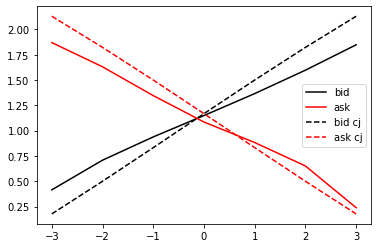

In [85]:
plt.plot(inventories, bid_actions, label = "bid", color = "k")
plt.plot(inventories, ask_actions, label = "ask", color = "r")
plt.plot(inventories, cj_bid_actions, label = "bid cj", color = "k", linestyle = "--")
plt.plot(inventories, cj_ask_actions, label = "ask cj", color = "r", linestyle = "--")
plt.legend()

In [86]:
timestamps = np.arange(0,1 + 0.01, 0.01)

In [87]:
bid_actions = {}
ask_actions = {}
for inventory in inventories:
    bid_actions[inventory] = []
    ask_actions[inventory] = []
    for timestamp in timestamps:
        bid_action, ask_action = agent.get_action(np.array([inventory, timestamp]))
        bid_actions[inventory].append(bid_action)
        ask_actions[inventory].append(ask_action)

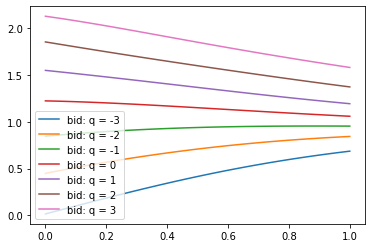

In [88]:
for inventory in inventories:
    plt.plot(timestamps, bid_actions[inventory], label=f"bid: q = {inventory}")
plt.legend()
plt.show()

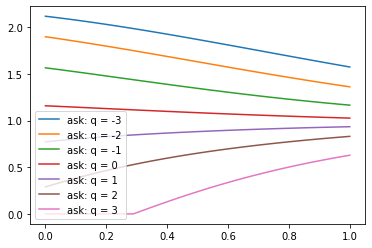

In [89]:
for inventory in inventories:
    plt.plot(timestamps, ask_actions[inventory], label=f"ask: q = {inventory}")
plt.legend()
plt.show()

In [90]:
model.save("trained_model")

In [91]:
loaded = PPO.load("trained_model.zip")

In [80]:
loaded